# Stock Price Analysis

What You'll Learn:
Time series data analysis

Moving averages, volatility

Basic forecasting (e.g., ARIMA or linear regression)

Tools:
Python, pandas, matplotlib/seaborn, yfinance, statsmodels

## Exploratory Data Analysis (EDA)

### 📈 Stock Price Analysis – Apple (AAPL)
This notebook fetches and visualizes historical stock data using Python and `yfinance`. We’ll begin with closing price trends and move toward technical indicators and forecasting.

In [1]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")


api_key = "DW1A1LWLSNJKD9WO"
ts = TimeSeries(key=api_key, output_format='pandas')

# ✅ Use free daily prices endpoint
data, meta = ts.get_daily(symbol='AAPL', outputsize='full')

# Clean up and sort
data = data.sort_index()
data.head()


,1. open,2. high,3. low,4. close,5. volume
date,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


In [2]:
# import the packages
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

# set up API key
api_key = "DW1A1LWLSNJKD9WO"
ts = TimeSeries(key=api_key, output_format='pandas')


In [29]:
# import all available Apple stock data from Alpha Vantage
# data, meta = ts.get_daily(symbol='AAPL', outputsize='full')
data, meta = ts.get_daily(symbol='AAPL', outputsize='full')

# sort by date
data = data.sort_index()

# rename columns for easier access
data.columns = [col.split('. ')[1] for col in data.columns]
data = data.rename(columns=lambda x: x.capitalize())

# preview cleaned data
data[['Close']].head()


,Close
date,
1999-11-01,77.62
1999-11-02,80.25
1999-11-03,81.50
1999-11-04,83.62
1999-11-05,88.31


In [4]:
# Calculate 20-day and 50-day Simpe Moving Averages (SMAs)
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# Preview with SMAs
data[['Close', 'SMA_20', 'SMA_50']].tail()


,Close,SMA_20,SMA_50
date,,,
2025-06-06,203.92,204.2710,203.6794
2025-06-09,201.45,204.4170,203.2314
2025-06-10,202.67,204.0110,202.9268
2025-06-11,198.78,203.3035,202.4598
2025-06-12,199.20,202.6470,201.9800


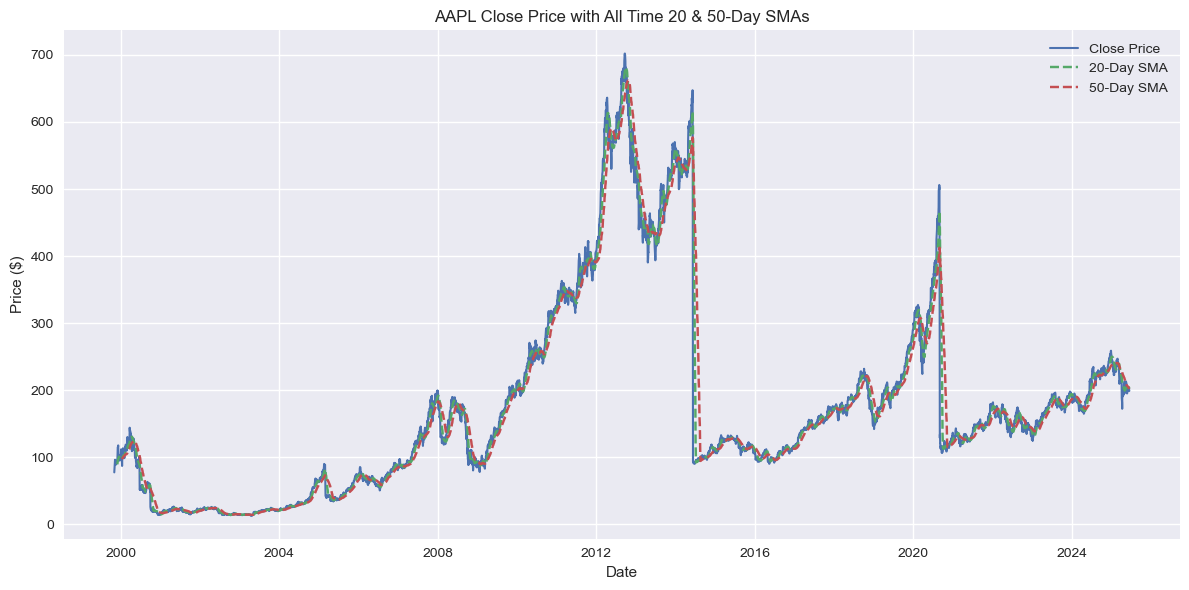

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', linewidth=1.5)
plt.plot(data['SMA_20'], label='20-Day SMA', linestyle='--')
plt.plot(data['SMA_50'], label='50-Day SMA', linestyle='--')

plt.title('AAPL Close Price with All Time 20 & 50-Day SMAs')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Large drops are indicative of stock splits. due to the use of a free plan for alpha vantgage, stock prices are not accounting of stock splits

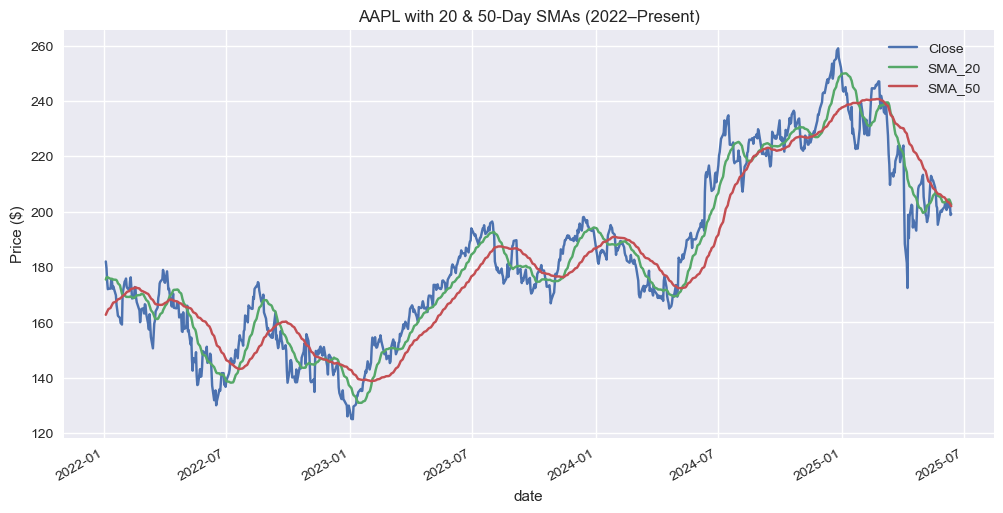

In [6]:
recent_data = data.loc["2022-01-01":]
recent_data[['Close', 'SMA_20', 'SMA_50']].plot(figsize=(12, 6))
plt.title("AAPL with 20 & 50-Day SMAs (2022–Present)")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()


In [7]:
# Initialize 'Signal' column to 0 (hold)
data['Signal'] = 0

# Set Signal to 1 (buy) when SMA_20 > SMA_50, else -1 (sell)
data.loc[data['SMA_20'] > data['SMA_50'], 'Signal'] = 1
data.loc[data['SMA_20'] < data['SMA_50'], 'Signal'] = -1


In [8]:
# Create 'Position' as the difference between today's and yesterday's signal
data['Position'] = data['Signal'].diff()


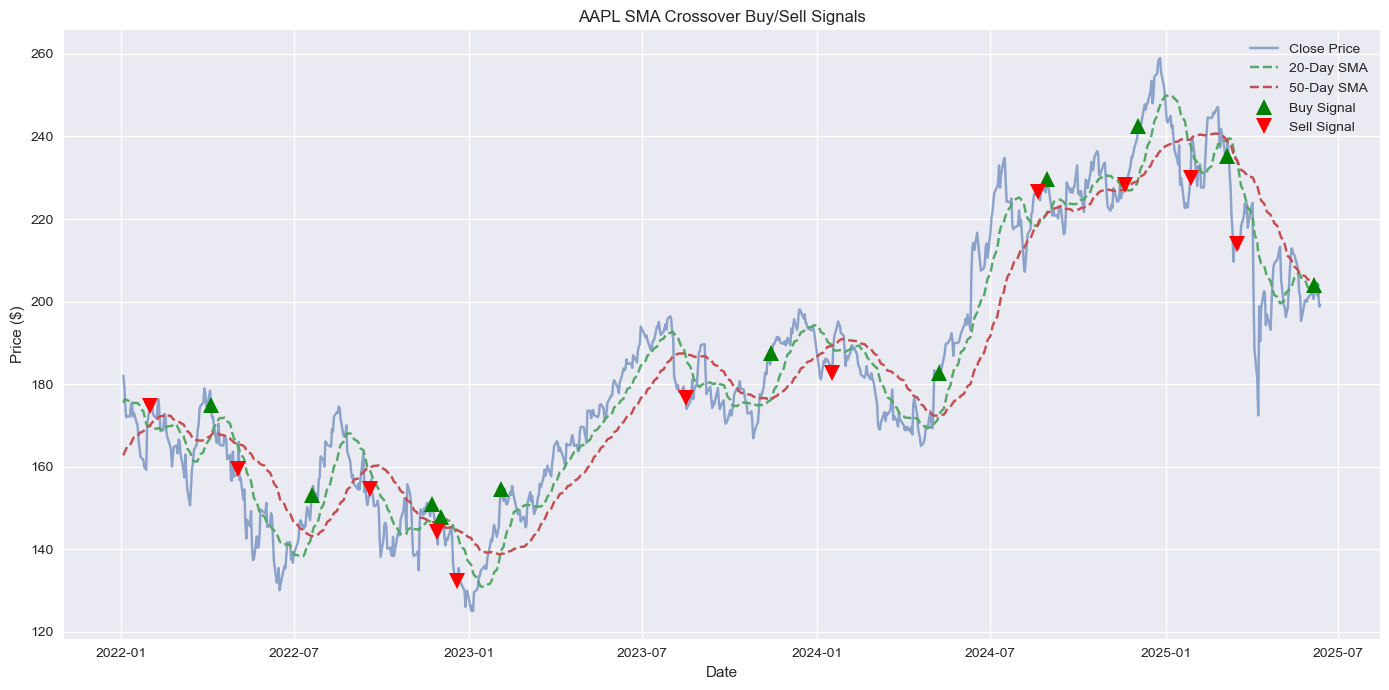

In [9]:
# Focus on recent data (last 2 years for clarity)
recent = data.loc["2022-01-01":]

plt.figure(figsize=(14, 7))
plt.plot(recent['Close'], label='Close Price', alpha=0.6)
plt.plot(recent['SMA_20'], label='20-Day SMA', linestyle='--')
plt.plot(recent['SMA_50'], label='50-Day SMA', linestyle='--')

# Plot buy signals
plt.plot(recent[recent['Position'] == 2].index,
         recent[recent['Position'] == 2]['Close'],
         '^', markersize=12, color='green', label='Buy Signal')

# Plot sell signals
plt.plot(recent[recent['Position'] == -2].index,
         recent[recent['Position'] == -2]['Close'],
         'v', markersize=12, color='red', label='Sell Signal')

plt.title('AAPL SMA Crossover Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Calculating Potential Returns using an SMA Strategy

We will forecast the percentage in returns if trades were made by following every single buy/sell signal. To ensure for accurate data, the data will only encompass trades that both have bought and sold after 2022.

In [10]:
# Make a copy to avoid modifying original
trades = data.copy()

# Only keep rows where a crossover occurs (buy or sell)
trades = trades[trades['Position'].isin([2, -2])]

# Reset index to work with rows by position
trades = trades.reset_index()

# Ensure we always buy first — drop leading sell if needed
if trades.iloc[0]['Position'] == -2:
    trades = trades.iloc[1:]

# If we have an unmatched buy at the end (no sell), drop it
if trades.iloc[-1]['Position'] == 2:
    trades = trades.iloc[:-1]

# Pair up buy and sell trades
buy_trades = trades[trades['Position'] == 2].reset_index(drop=True)
sell_trades = trades[trades['Position'] == -2].reset_index(drop=True)

# Combine buy and sell trades into a single DataFrame
paired_trades = pd.DataFrame({
    'buy_date': buy_trades['date'],
    'buy_price': buy_trades['Close'],
    'sell_date': sell_trades['date'],
    'sell_price': sell_trades['Close']
})

# ✅ Filter for only those trades where both buy AND sell were after 2022
paired_trades = paired_trades[paired_trades['sell_date'] >= "2022-01-01"]
paired_trades = paired_trades[paired_trades['buy_date'] >= "2022-01-01"]

# Compute returns
returns = (paired_trades['sell_price'] - paired_trades['buy_price']) / paired_trades['buy_price']

# Basic stats
total_trades = len(returns)
profitable_trades = (returns > 0).sum()
losing_trades = (returns <= 0).sum()
win_rate = profitable_trades / total_trades
avg_return = returns.mean()
total_return = returns.sum()

# Print results
print(f"Total trades: {total_trades}")
print(f"Winning trades: {profitable_trades}")
print(f"Losing trades: {losing_trades}")
print(f"Win rate: {win_rate:.2%}")
print(f"Average return per trade: {avg_return:.2%}")
print(f"Total cumulative return: {total_return:.2%}")


Total trades: 10
Winning trades: 3
Losing trades: 7
Win rate: 30.00%
Average return per trade: -0.22%
Total cumulative return: -2.23%


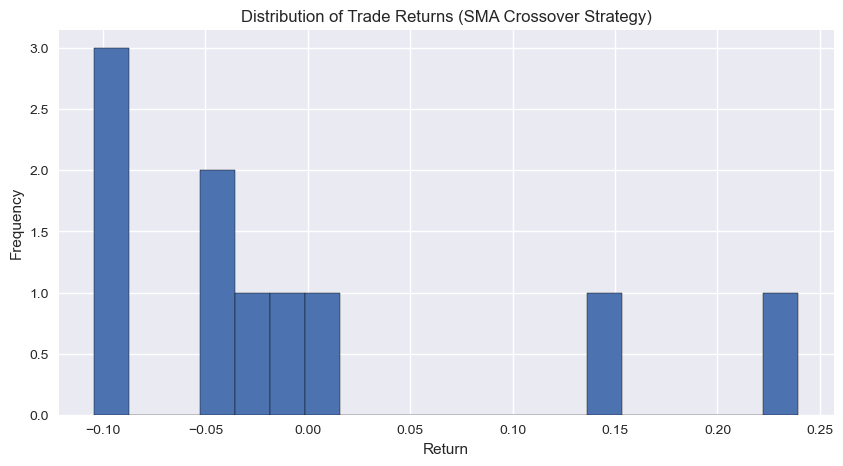

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(returns, bins=20, edgecolor='black')
plt.title("Distribution of Trade Returns (SMA Crossover Strategy)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Calculating Potential Returns Using a Buy and Hold Strategy
We will forecast the percentage in returns if trades were made on Jan 1, 2022 and held until present. To ensure for accurate data, the data will only encompass trades that both have bought and sold after 2022. This will then be compared to our previous SMA strategy to analyze what resulted in higher returns.

In [12]:
# Get the exact date range to match SMA strategy (2022 onward)
start_date = pd.to_datetime("2022-01-01")
end_date = data.index.max()  # most recent available date

# Slice the data accordingly
price_range = data.loc[start_date:end_date]

# Buy-and-hold return from Jan 1, 2022 to present
start_price = price_range['Close'].iloc[0]
end_price = price_range['Close'].iloc[-1]
buy_hold_return = (end_price - start_price) / start_price

print(f"Buy-and-Hold Return (2022–present): {buy_hold_return:.2%}")
print(f"Total cumulative return (SMA strategy): {total_return:.2%}")


Buy-and-Hold Return (2022–present): 9.44%
Total cumulative return (SMA strategy): -2.23%


In [13]:
def run_sma_strategy(data, short_window, long_window, start_eval_date="2022-01-01", verbose=False):
    df = data.copy()
    df[f'SMA_{short_window}'] = df['Close'].rolling(window=short_window).mean()
    df[f'SMA_{long_window}'] = df['Close'].rolling(window=long_window).mean()

    df['Signal'] = 0
    df.loc[df[f'SMA_{short_window}'] > df[f'SMA_{long_window}'], 'Signal'] = 1
    df.loc[df[f'SMA_{short_window}'] < df[f'SMA_{long_window}'], 'Signal'] = -1
    df['Position'] = df['Signal'].diff()

    trades = df[df['Position'].isin([2, -2])].reset_index()

    if len(trades) < 2:
        return None

    if trades.iloc[0]['Position'] == -2:
        trades = trades.iloc[1:]
    if trades.iloc[-1]['Position'] == 2:
        trades = trades.iloc[:-1]

    buy_trades = trades[trades['Position'] == 2].reset_index(drop=True)
    sell_trades = trades[trades['Position'] == -2].reset_index(drop=True)

    paired_trades = pd.DataFrame({
        'buy_date': buy_trades['date'],
        'buy_price': buy_trades['Close'],
        'sell_date': sell_trades['date'],
        'sell_price': sell_trades['Close']
    })

    paired_trades = paired_trades[
        (paired_trades['buy_date'] >= start_eval_date) &
        (paired_trades['sell_date'] >= start_eval_date)
    ]

    if paired_trades.empty:
        return None

    returns = (paired_trades['sell_price'] - paired_trades['buy_price']) / paired_trades['buy_price']
    if len(returns) == 0:
        return None

    total_trades = len(returns)
    win_rate = (returns > 0).mean()
    avg_return = returns.mean()
    total_return = returns.sum()

    # Buy-and-hold for same period
    price_range = df.loc[start_eval_date:]
    if price_range.empty:
        return None

    start_price = price_range['Close'].iloc[0]
    end_price = price_range['Close'].iloc[-1]
    buy_hold_return = (end_price - start_price) / start_price

    if verbose:
        print(f"SMA({short_window}/{long_window}) | Trades: {total_trades}, Win rate: {win_rate:.2%}, SMA return: {total_return:.2%}, Buy&Hold: {buy_hold_return:.2%}")

    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'avg_return': avg_return,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return
    }


In [14]:
run_sma_strategy(data, 10, 30)
run_sma_strategy(data, 50, 200)


{'total_trades': 3,
 'win_rate': 0.3333333333333333,
 'avg_return': -0.05130849379698274,
 'total_return': -0.15392548139094822,
 'buy_hold_return': 0.09444536014504697}

## Statistical Analysis

We will begin by applying this function to all the stocks in the S&P 500 to garner data on the percentage of returns for the SMA strategy for 20/50, 10/30, and 50/200 and the buy and hold return percentages.
Afterwards, we will run a statistical test to test whether it is more effective to use SMA strategies or buy and hold for the S&P 500.

In [15]:
# Scrape S&P 500 tickers from Wikipedia
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)[0]
    return table['Symbol'].tolist()

tickers = get_sp500_tickers()
print(f"{tickers[:5]}")  # Preview first 5 tickers
print(f"{len(tickers)}")

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']
503


In [110]:
def twelvedata_run_sma_strategy(data, short_window, long_window, start_eval_date="2022-01-01", verbose=False):
    import pandas as pd

    # Standardize column names (especially important for Twelve Data)
    data = data.rename(columns=lambda x: x.capitalize())
    df = data.copy()

    required_cols = {'Date', 'Close'}
    if not required_cols.issubset(df.columns):
        if verbose:
            print(f"Missing required columns: {required_cols - set(df.columns)}")
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # Calculate SMAs
    df[f'SMA_{short_window}'] = df['Close'].rolling(window=short_window).mean()
    df[f'SMA_{long_window}'] = df['Close'].rolling(window=long_window).mean()

    # Generate signals
    df['Signal'] = 0
    df.loc[df[f'SMA_{short_window}'] > df[f'SMA_{long_window}'], 'Signal'] = 1
    df.loc[df[f'SMA_{short_window}'] < df[f'SMA_{long_window}'], 'Signal'] = -1
    df['Position'] = df['Signal'].diff()

    trades = df[df['Position'].isin([2, -2])].reset_index()

    # Not enough trades to analyze
    if len(trades) < 2:
        return None

    # Ensure buy comes first and last trade is matched
    if trades.iloc[0]['Position'] == -2:
        trades = trades.iloc[1:]
    if trades.iloc[-1]['Position'] == 2:
        trades = trades.iloc[:-1]

    # Pair up buys and sells
    buy_trades = trades[trades['Position'] == 2].reset_index(drop=True)
    sell_trades = trades[trades['Position'] == -2].reset_index(drop=True)

    paired_trades = pd.DataFrame({
        'buy_date': buy_trades['Date'],
        'buy_price': buy_trades['Close'],
        'sell_date': sell_trades['Date'],
        'sell_price': sell_trades['Close']
    })

    # Filter only trades that were both entered and exited after start date
    paired_trades = paired_trades[
        (paired_trades['buy_date'] >= start_eval_date) &
        (paired_trades['sell_date'] >= start_eval_date)
    ]

    if paired_trades.empty:
        return None

    # Compute returns
    returns = (paired_trades['sell_price'] - paired_trades['buy_price']) / paired_trades['buy_price']
    if len(returns) == 0:
        return None

    total_trades = len(returns)
    win_rate = (returns > 0).mean()
    avg_return = returns.mean()
    total_return = returns.sum()

    # Buy-and-hold over same evaluation period
    price_range = df.loc[start_eval_date:]
    if price_range.empty:
        return None

    start_price = price_range['Close'].iloc[0]
    end_price = price_range['Close'].iloc[-1]
    buy_hold_return = (end_price - start_price) / start_price

    if verbose:
        print(f"SMA({short_window}/{long_window}) | Trades: {total_trades}, Win rate: {win_rate:.2%}, "
              f"SMA return: {total_return:.2%}, Buy&Hold: {buy_hold_return:.2%}")

    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'avg_return': avg_return,
        'total_return': total_return,
        'buy_hold_return': buy_hold_return
    }


In [42]:
from twelvedata import TDClient

td = TDClient(apikey="7ccd3acdc41c4a3a91a494d731f95314")  # Replace with your key

def get_td_data(ticker):
    import requests
    import pandas as pd

    url = f"https://api.twelvedata.com/time_series?symbol={ticker}&interval=1day&outputsize=5000&apikey=7ccd3acdc41c4a3a91a494d731f95314"
    response = requests.get(url)
    data = response.json()

    if "values" not in data:
        print(f"{ticker} failed: {data.get('message', 'Unknown error')}")
        return None

    df = pd.DataFrame(data["values"])
    df = df.rename(columns={
        "datetime": "Date",
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Close",
        "volume": "Volume"
    })

    df["Date"] = pd.to_datetime(df["Date"])

    # Convert all numeric columns to float
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.sort_values("Date").reset_index(drop=True)
    return df


In [44]:
df = get_td_data("AAPL")  # or any test ticker

print(df.head())          # See the first few rows of data
print(df.columns)         # See all column names
print(df.dtypes)          # Check data types

        Date     Open     High      Low    Close     Volume
0 2005-07-29  1.55571  1.58500  1.50929  1.52321  562080400
1 2005-08-01  1.52036  1.53857  1.50286  1.52679  314249600
2 2005-08-02  1.53179  1.55357  1.52179  1.54250  296875600
3 2005-08-03  1.54250  1.54679  1.52750  1.54357  258322400
4 2005-08-04  1.53179  1.53571  1.51036  1.52536  269304000
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


In [45]:
# For loop to extract all data AND run financial calculations for 10/30 SMA strategy and buy and hold return percentages

from tqdm import tqdm
import time

results = []

# Wrap your tickers in tqdm for progress bar
for ticker in tqdm(tickers, desc="Processing tickers"):
    df = get_td_data(ticker)
    time.sleep(12)

    if df is None or df.empty:
        continue

    # Check if required columns exist before proceeding
    required_cols = {'Date', 'Open', 'High', 'Low', 'Close', 'Volume'}
    if not required_cols.issubset(df.columns):
        print(f"{ticker} skipped: missing required columns")
        continue

    try:
        metrics = twelvedata_run_sma_strategy(df, 10, 30)
        if metrics:
            results.append({'ticker': ticker, **metrics})
    except Exception as e:
        print(f"{ticker} failed during SMA strategy: {e}")



Processing tickers: 100%|██████████| 503/503 [1:49:25<00:00, 13.05s/it]


20/50, 10/30, and 50/200

In [96]:
# For loop that only runs the financial calculations for SMA strategy and buy and hold return percentages

# Wrap your tickers in tqdm for progress bar
for ticker in tqdm(tickers, desc="Processing tickers"):
    # df = get_td_data(ticker)
    # time.sleep(12)

    df = df
    
    if df is None or df.empty:
        continue

    # Check if required columns exist before proceeding
    required_cols = {'Date', 'Open', 'High', 'Low', 'Close', 'Volume'}
    if not required_cols.issubset(df.columns):
        print(f"{ticker} skipped: missing required columns")
        continue

    try:
        metrics = twelvedata_run_sma_strategy(df, 10, 30) # change these numbers to 50, 200 for 50/200 SMA strategy or 20, 50 for 20/50 SMA strategy
        if metrics:
            results.append({'ticker': ticker, **metrics})
    except Exception as e:
        print(f"{ticker} failed during SMA strategy: {e}")

Processing tickers: 100%|██████████| 503/503 [00:05<00:00, 83.87it/s] 


In [88]:
results_df = pd.DataFrame(results)
results_df = results_df.iloc[:503]  # keeps rows 0 through 502 (total of 503 rows)

In [97]:
results_df = pd.DataFrame(results)
results_df.to_csv("sma_strategy_results.csv", index=False)
print("Saved SMA strategy results to CSV.")

Saved SMA strategy results to CSV.


In [95]:
results = results[:0]
len(results)

0

# Testing Multiple at Once

In [98]:
def single_sma_strategy(df, short_window, long_window, start_eval_date="2022-01-01"):
    df = df.copy()
    df[f'SMA_{short_window}'] = df['Close'].rolling(window=short_window).mean()
    df[f'SMA_{long_window}'] = df['Close'].rolling(window=long_window).mean()

    df['Signal'] = 0
    df.loc[df[f'SMA_{short_window}'] > df[f'SMA_{long_window}'], 'Signal'] = 1
    df.loc[df[f'SMA_{short_window}'] < df[f'SMA_{long_window}'], 'Signal'] = -1
    df['Position'] = df['Signal'].diff()

    trades = df[df['Position'].isin([2, -2])].reset_index()

    if len(trades) < 2:
        return None

    if trades.iloc[0]['Position'] == -2:
        trades = trades.iloc[1:]
    if trades.iloc[-1]['Position'] == 2:
        trades = trades.iloc[:-1]

    buy_trades = trades[trades['Position'] == 2].reset_index(drop=True)
    sell_trades = trades[trades['Position'] == -2].reset_index(drop=True)

    paired_trades = pd.DataFrame({
        'buy_date': buy_trades['Date'],
        'buy_price': buy_trades['Close'],
        'sell_date': sell_trades['Date'],
        'sell_price': sell_trades['Close']
    })

    paired_trades = paired_trades[
        (paired_trades['buy_date'] >= start_eval_date) &
        (paired_trades['sell_date'] >= start_eval_date)
    ]

    if paired_trades.empty:
        return None

    returns = (paired_trades['sell_price'] - paired_trades['buy_price']) / paired_trades['buy_price']
    if len(returns) == 0:
        return None

    total_return = returns.sum()

    # Buy-and-hold for same period
    price_range = df.loc[df['Date'] >= start_eval_date]
    if price_range.empty:
        return None

    start_price = price_range['Close'].iloc[0]
    end_price = price_range['Close'].iloc[-1]
    buy_hold_return = (end_price - start_price) / start_price

    return total_return, buy_hold_return


In [113]:
def twelvedata_run_sma_strategy(data, start_eval_date="2022-01-01"):
    df = data.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

    # Compute Buy-and-Hold return
    price_range = df[df["Date"] >= start_eval_date]
    if price_range.empty:
        return None
    start_price = price_range["Close"].iloc[0]
    end_price = df["Close"].iloc[-1]
    buy_hold_return = (end_price - start_price) / start_price

    result = {
        "buy_hold_return": buy_hold_return
    }

    # List of SMA strategies
    sma_pairs = [(10, 30), (20, 50), (50, 200)]

    for short_window, long_window in sma_pairs:
        df[f"SMA_{short_window}"] = df["Close"].rolling(window=short_window).mean()
        df[f"SMA_{long_window}"] = df["Close"].rolling(window=long_window).mean()

        df["Signal"] = 0
        df.loc[df[f"SMA_{short_window}"] > df[f"SMA_{long_window}"], "Signal"] = 1
        df.loc[df[f"SMA_{short_window}"] < df[f"SMA_{long_window}"], "Signal"] = -1
        df["Position"] = df["Signal"].diff()

        trades = df[df["Position"].isin([2, -2])].reset_index(drop=True)
        if trades.empty or len(trades) < 2:
            continue

        if trades.iloc[0]["Position"] == -2:
            trades = trades.iloc[1:]
        if trades.iloc[-1]["Position"] == 2:
            trades = trades.iloc[:-1]

        buy_trades = trades[trades["Position"] == 2].reset_index(drop=True)
        sell_trades = trades[trades["Position"] == -2].reset_index(drop=True)

        paired_trades = pd.DataFrame({
            "buy_date": buy_trades["Date"],
            "buy_price": buy_trades["Close"],
            "sell_date": sell_trades["Date"],
            "sell_price": sell_trades["Close"]
        })

        paired_trades = paired_trades[
            (paired_trades["buy_date"] >= start_eval_date) &
            (paired_trades["sell_date"] >= start_eval_date)
        ]

        if paired_trades.empty:
            continue

        returns = (paired_trades["sell_price"] - paired_trades["buy_price"]) / paired_trades["buy_price"]
        if returns.empty:
            continue

        total_trades = len(returns)
        win_rate = (returns > 0).mean()
        avg_return = returns.mean()
        total_return = returns.sum()

        key_prefix = f"sma_{short_window}_{long_window}"
        result[f"{key_prefix}_return"] = total_return
        result[f"{key_prefix}_trades"] = total_trades
        result[f"{key_prefix}_winrate"] = win_rate

    return result if len(result) > 1 else None  # Only return if SMA results exist


In [114]:
from tqdm import tqdm
import time

results = []

for ticker in tqdm(tickers[:10], desc="Processing tickers"):  # Limit to first 10 tickers
    df = get_td_data(ticker)
    time.sleep(12)  # Respect Twelve Data free-tier rate limit

    if df is None or df.empty:
        continue

    try:
        strategy_results = twelvedata_run_sma_strategy(df)
        if strategy_results:
            results.append({
                "ticker": ticker,
                **strategy_results
            })
    except Exception as e:
        print(f"{ticker} failed: {e}")


Processing tickers: 100%|██████████| 10/10 [02:15<00:00, 13.53s/it]


In [115]:
results

[{'ticker': 'MMM',
  'buy_hold_return': -0.02585288339673667,
  'sma_10_30_return': 0.022744703106918278,
  'sma_10_30_trades': 18,
  'sma_10_30_winrate': 0.3333333333333333,
  'sma_20_50_return': 0.18366717588947976,
  'sma_20_50_trades': 10,
  'sma_20_50_winrate': 0.4,
  'sma_50_200_return': -0.14570637106877118,
  'sma_50_200_trades': 1,
  'sma_50_200_winrate': 0.0},
 {'ticker': 'AOS',
  'buy_hold_return': -0.2311834390331458,
  'sma_10_30_return': -0.18054565222443314,
  'sma_10_30_trades': 20,
  'sma_10_30_winrate': 0.3,
  'sma_20_50_return': -0.12186408603367052,
  'sma_20_50_trades': 9,
  'sma_20_50_winrate': 0.4444444444444444,
  'sma_50_200_return': 0.14459619972873833,
  'sma_50_200_trades': 2,
  'sma_50_200_winrate': 1.0},
 {'ticker': 'ABT',
  'buy_hold_return': -0.01862768361905787,
  'sma_10_30_return': 0.14614426173081307,
  'sma_10_30_trades': 14,
  'sma_10_30_winrate': 0.35714285714285715,
  'sma_20_50_return': -0.15706782525264731,
  'sma_20_50_trades': 9,
  'sma_20_50

In [117]:
results_df = pd.DataFrame(results)
results_df.to_csv("sma_strategy_results.csv", index=False)
print("Saved SMA strategy results to CSV.")

Saved SMA strategy results to CSV.


In [118]:
results_df.head()

,ticker,buy_hold_return,sma_10_30_return,sma_10_30_trades,sma_10_30_winrate,sma_20_50_return,sma_20_50_trades,sma_20_50_winrate,sma_50_200_return,sma_50_200_trades,sma_50_200_winrate
0,MMM,-0.025853,0.022745,18,0.333333,0.183667,10,0.400000,-0.145706,1,0.00
1,AOS,-0.231183,-0.180546,20,0.300000,-0.121864,9,0.444444,0.144596,2,1.00
2,ABT,-0.018628,0.146144,14,0.357143,-0.157068,9,0.333333,-0.249563,3,0.00
3,ABBV,0.420913,0.200981,14,0.428571,0.005420,8,0.500000,-0.284718,4,0.25
4,ACN,-0.218757,-0.139242,15,0.266667,-0.291712,10,0.300000,-0.151174,2,0.50


# Data Visualizations

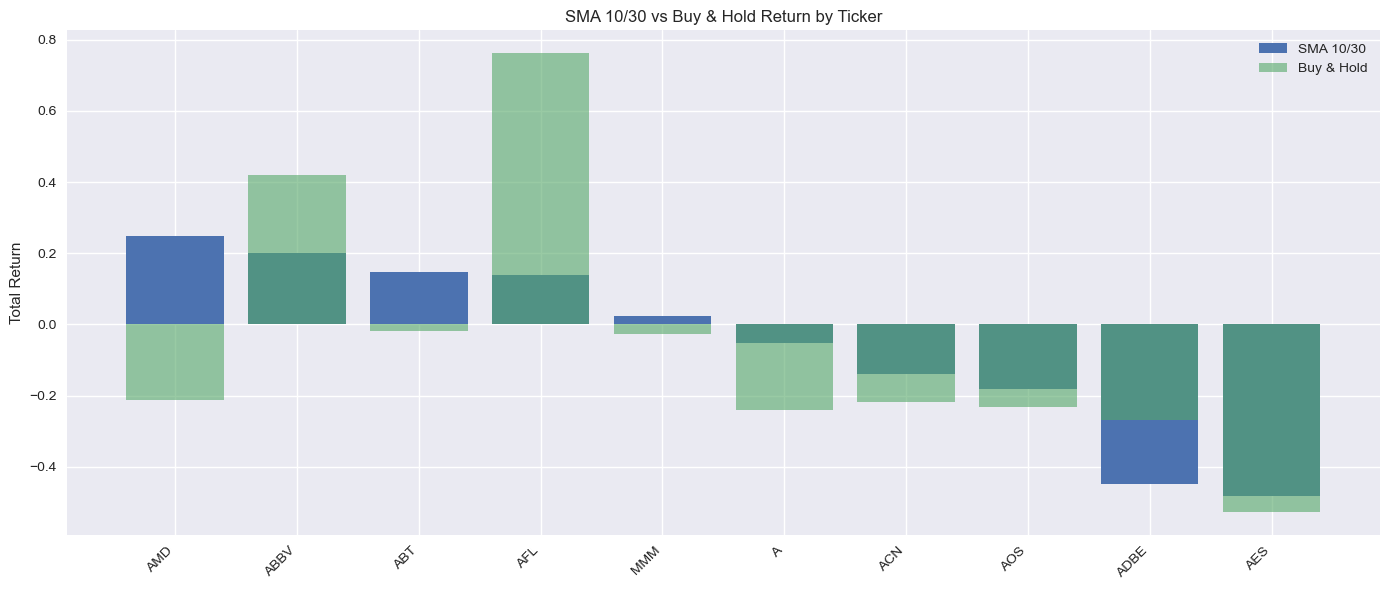

In [119]:
import matplotlib.pyplot as plt

# Sort by SMA 10/30 return
sorted_df = results_df.sort_values(by='sma_10_30_return', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(sorted_df['ticker'], sorted_df['sma_10_30_return'], label='SMA 10/30')
plt.bar(sorted_df['ticker'], sorted_df['buy_hold_return'], alpha=0.6, label='Buy & Hold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Return')
plt.title('SMA 10/30 vs Buy & Hold Return by Ticker')
plt.legend()
plt.tight_layout()
plt.show()


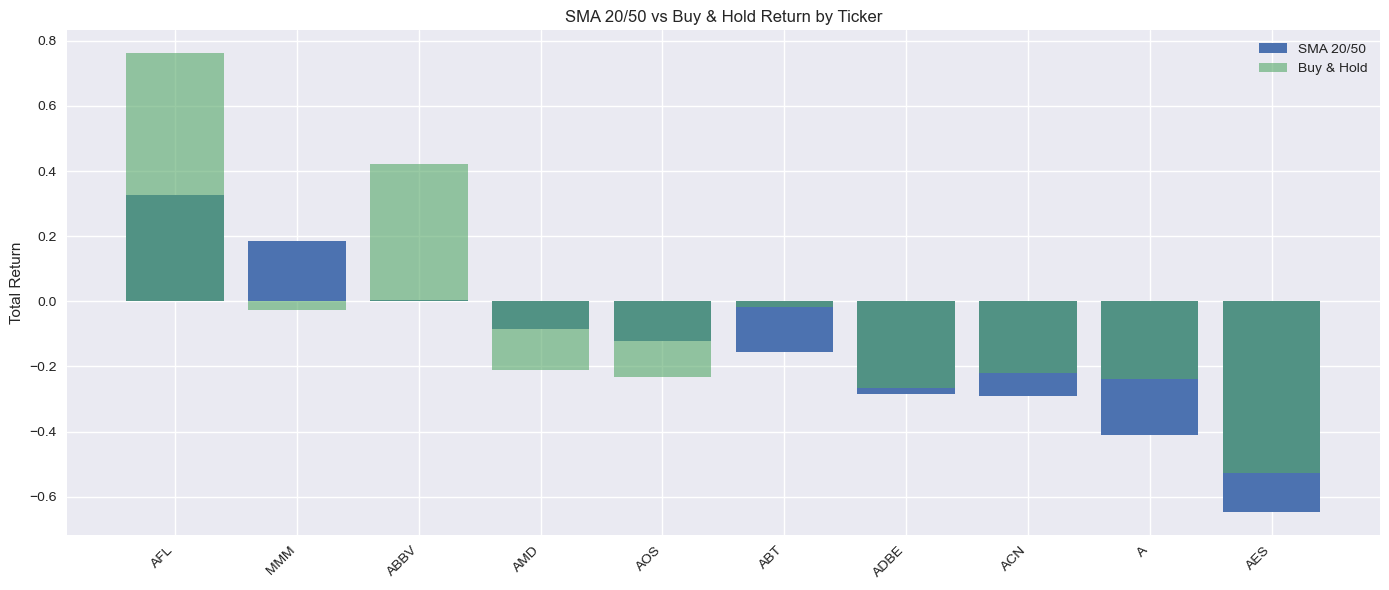

In [120]:
import matplotlib.pyplot as plt

# Sort by SMA 20/50 return
sorted_df = results_df.sort_values(by='sma_20_50_return', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(sorted_df['ticker'], sorted_df['sma_20_50_return'], label='SMA 20/50')
plt.bar(sorted_df['ticker'], sorted_df['buy_hold_return'], alpha=0.6, label='Buy & Hold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Return')
plt.title('SMA 20/50 vs Buy & Hold Return by Ticker')
plt.legend()
plt.tight_layout()
plt.show()


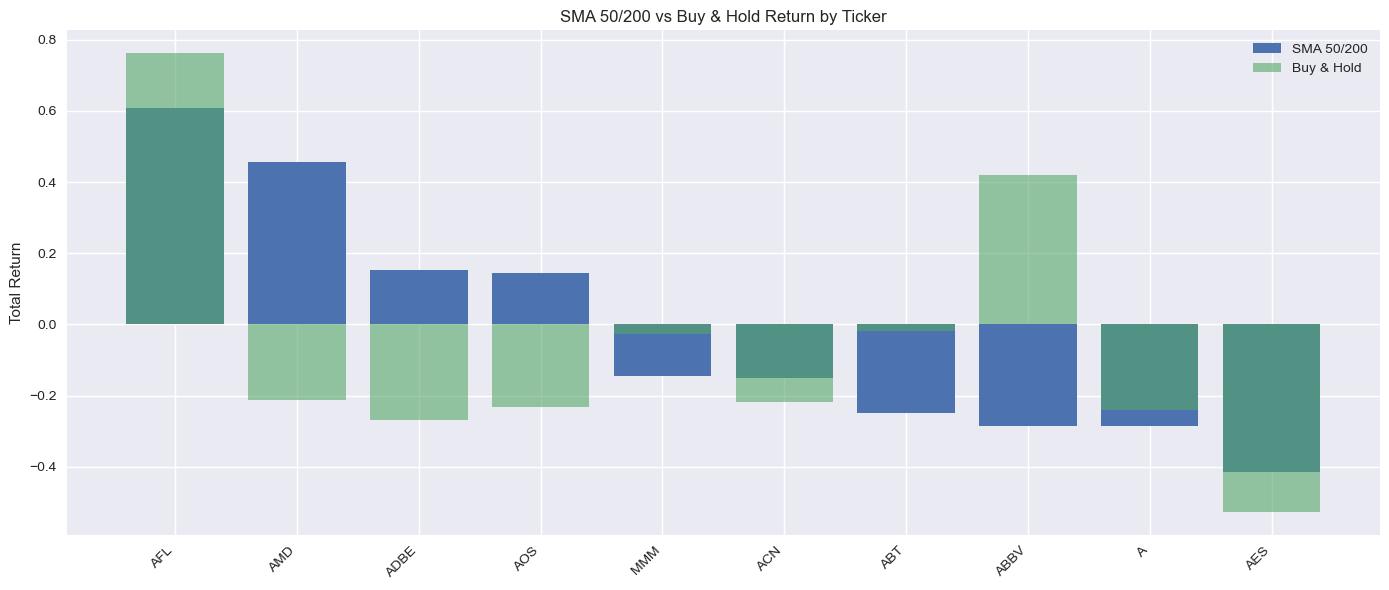

In [121]:
import matplotlib.pyplot as plt

# Sort by SMA 50/200 return
sorted_df = results_df.sort_values(by='sma_50_200_return', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(sorted_df['ticker'], sorted_df['sma_50_200_return'], label='SMA 50/200')
plt.bar(sorted_df['ticker'], sorted_df['buy_hold_return'], alpha=0.6, label='Buy & Hold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Return')
plt.title('SMA 50/200 vs Buy & Hold Return by Ticker')
plt.legend()
plt.tight_layout()
plt.show()


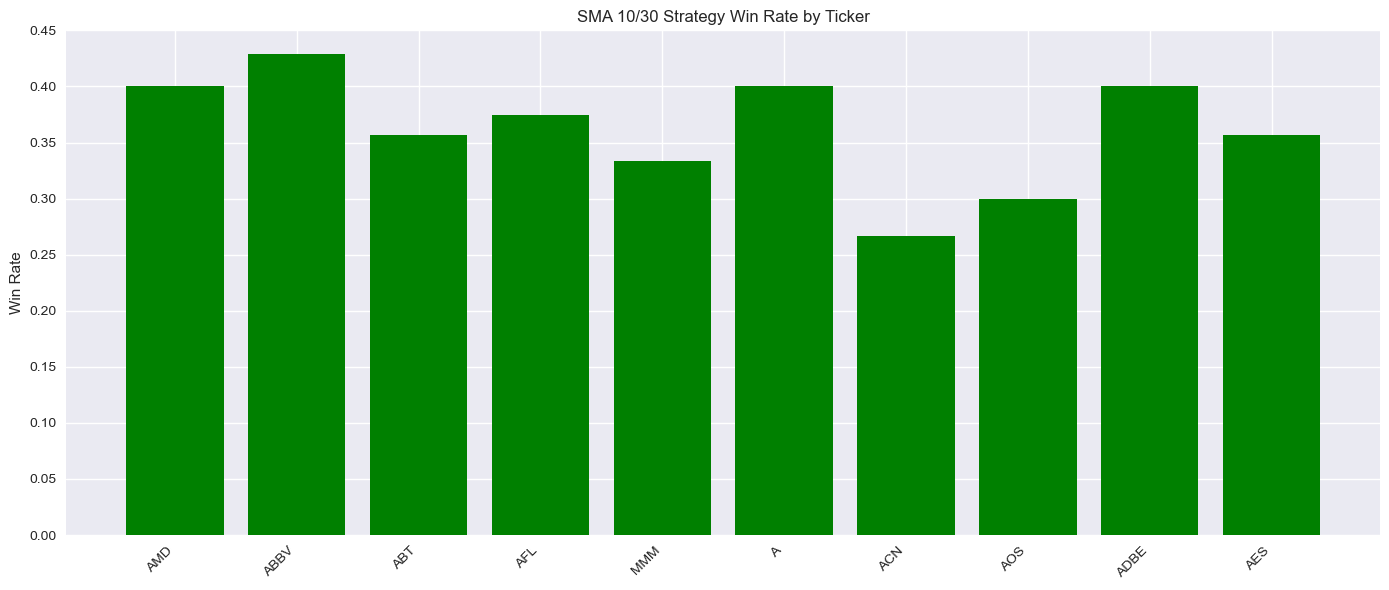

In [124]:
plt.figure(figsize=(14, 6))
plt.bar(sorted_df['ticker'], sorted_df['sma_10_30_winrate'], color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Win Rate')
plt.title('SMA 10/30 Strategy Win Rate by Ticker')
plt.tight_layout()
plt.show()


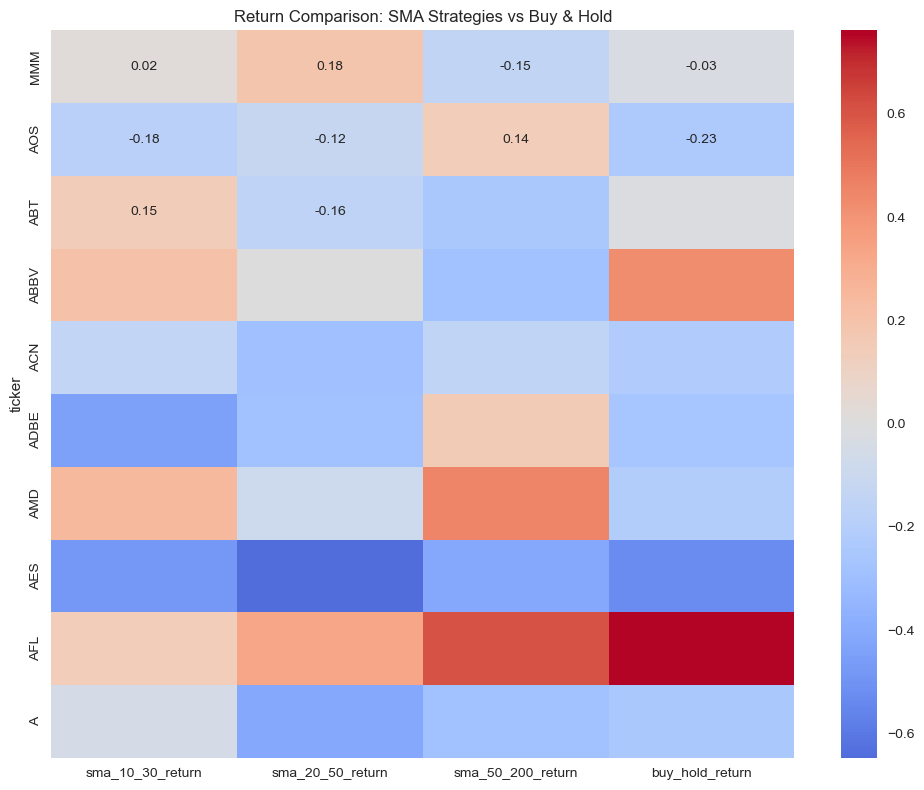

In [125]:
import seaborn as sns

returns_subset = results_df.set_index('ticker')[
    ['sma_10_30_return', 'sma_20_50_return', 'sma_50_200_return', 'buy_hold_return']
]

plt.figure(figsize=(10, 8))
sns.heatmap(returns_subset, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Return Comparison: SMA Strategies vs Buy & Hold")
plt.tight_layout()
plt.show()
